# Data Modeling
We now have combined and cleaned data that can be used for modelling. Our dataset `offer_complete_df` contains all the offer viewed records for the bogo and discount offer types. Each record indicated if the offer that was viewed was also completed by the user.

We will use this information to predict if, for a given offer and user with their demographics, the offer will be completed.

In [32]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# read parquet files into dataframes
# offer_df = pd.read_parquet('data/offer_df.parquet')
offer_complete_df = pd.read_parquet('data/offer_complete_df.parquet')
transaction_df = pd.read_parquet('data/transaction_df.parquet')

In [33]:
offer_complete_df.sample(n=3)

,age,income,days_as_member,F,M,O,reward,difficulty,duration,bogo,discount,email,mobile,social,web,offer_viewed_and_completed
20663,69.0,41000.0,3100.0,0.0,1.0,0.0,2.0,10.0,10.0,0.0,1.0,1.0,1.0,1.0,1.0,1
20839,51.0,92000.0,2858.0,1.0,0.0,0.0,5.0,5.0,5.0,1.0,0.0,1.0,1.0,1.0,1.0,0
274945,63.0,74000.0,1862.0,0.0,1.0,0.0,5.0,5.0,5.0,1.0,0.0,1.0,1.0,1.0,1.0,0


In [34]:
# we do not have imbalanced data (can use accuracy as metric)
offer_complete_df.offer_viewed_and_completed.value_counts(normalize=True)

1    0.554568
0    0.445432
Name: offer_viewed_and_completed, dtype: float64

## Model
We will be using the sklearn framework and a XGBoost model (binary classification) to do this prediction.

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

data = offer_complete_df
# assign offer_viewed_and_completed as target column
X,y = data.iloc[:,:-1], data['offer_viewed_and_completed']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6851851851851852
Precision: 0.7018339171646404
Recall: 0.7553781326236416
F1-score: 0.727622302926725
AUC: 0.6762131543095931


## Model results interpretation
The model acieved the following:  
Accuracy: The model predicted whether a user would complete and offer or not 68% of the time.  
Precision: 70% of the time that a model predicted an offer would be completed was correct.  
Recall: The model was able to identify 75% of the cases where an offer would be completed.  
F1-score: This metric balances precision and recall with a score of 72%.  

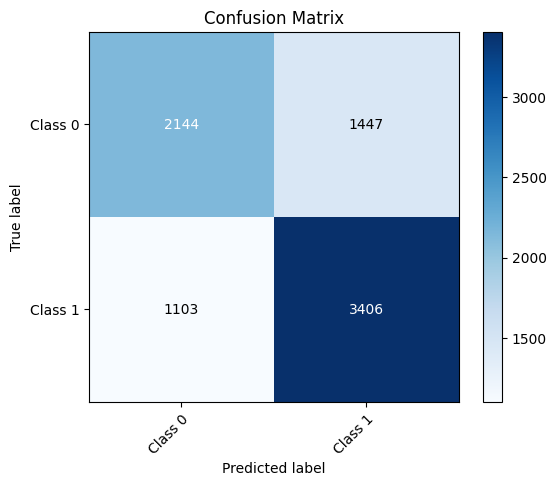

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are the true labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)

# Define class labels
classes = ['Class 0', 'Class 1']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as a heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels for x and y axes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label')

# Rotate the x-axis labels if needed
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Set a title for the plot
ax.set_title("Confusion Matrix")

# Display the plot
plt.show()


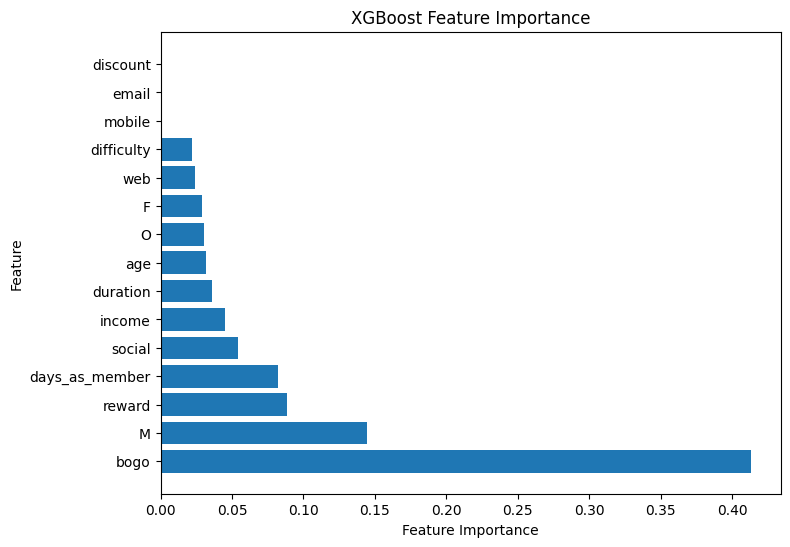

In [43]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model is the trained XGBoost classifier
# If not, make sure to train an XGBoost classifier before this step

# Get feature importance scores from the trained XGBoost model
importance_scores = xgb_model.feature_importances_

# Get feature names
feature_names = data.iloc[:,:-1].columns  # Replace with your actual feature names

# Sort feature importance scores and feature names in descending order
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_scores)), sorted_scores, align='center')
plt.yticks(range(len(sorted_scores)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()


## Transactions Analysis (Future work)
Now that we can predict if a user will complete and offer, it will be useful to see which users are the customers with the highest transaction values. This may be useful to see which offers these users respond to best.


In [36]:
transaction_df.sample(n=5)

,event,time,amount,age,user_id,income,days_as_member,F,M,O,bogo,discount,informational
50762,transaction,150,12.45,56.0,9d029c11f8b349cb97f41b794adb8158,49000.0,2032.0,1.0,0.0,0.0,NaN,NaN,NaN
280680,transaction,618,27.79,63.0,65a9ceafbc3a42c696cf7ff2e45a3363,76000.0,2521.0,1.0,0.0,0.0,NaN,NaN,NaN
50015,transaction,144,15.93,28.0,a0c805c115194eb9ae7bca089b5b9f58,58000.0,2022.0,1.0,0.0,0.0,NaN,NaN,NaN
140617,transaction,372,34.10,80.0,528e528df85f418c912cd34d010b97d7,116000.0,2308.0,1.0,0.0,0.0,NaN,NaN,NaN
97391,transaction,258,2.78,38.0,1eeb590787164a088942327775c335e4,64000.0,2794.0,0.0,1.0,0.0,NaN,NaN,NaN


In [37]:
# create a correlation matrix with amount
amount_corr = transaction_df.corr()[['amount']].sort_values(by='amount', ascending=False)
amount_corr

,amount
amount,1.000000
income,0.237198
age,0.091624
F,0.089546
time,0.005502
O,0.003051
days_as_member,-0.033388
M,-0.089781
bogo,NaN
discount,NaN


In [38]:
transaction_df[transaction_df.user_id =='27573d3ebc154a48a9cd245ae16b71a2']

,event,time,amount,age,user_id,income,days_as_member,F,M,O,bogo,discount,informational
38957,transaction,84,1.00,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1970.0,0.0,1.0,0.0,NaN,NaN,NaN
107542,transaction,312,3.66,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1970.0,0.0,1.0,0.0,NaN,NaN,NaN
110383,transaction,330,5.81,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1970.0,0.0,1.0,0.0,NaN,NaN,NaN
282668,transaction,624,2.31,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1970.0,0.0,1.0,0.0,NaN,NaN,NaN


In [39]:
# group the transactions by user_id and sum the amount
transaction_df_group = transaction_df.groupby('user_id').agg({'amount': 'sum'}).reset_index()
transaction_df_group.head()

,user_id,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,0011e0d4e6b944f998e987f904e8c1e5,79.46
2,0020c2b971eb4e9188eac86d93036a77,196.86
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05
4,003d66b6608740288d6cc97a6903f4f0,48.34


In [40]:
# Future to-do, analyse which customers spend the most and target them with offers